[View in Colaboratory](https://colab.research.google.com/github/mogamin/chainer-examples/blob/master/chainer_PotatoChips_Classification_CNN2.ipynb)

In [1]:
# 
#![ ! -e ./data ] && curl -L "https://rebrand.ly/dllab2018-hackathon-cv" -o data.tar.gz && gzip -d -c data.tar.gz | tar xf -

#!apt-get install -y -qq libcusparse8.0 libnvrtc8.0 libnvtoolsext1
#!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
#!pip install cupy-cuda80==4.3.0 
#!pip install chainer==4.3.0
#!pip install chainercv
#!python -c 'import chainer; chainer.print_runtime_info()'

import chainer
import chainercv
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


In [0]:
#!sort -R data/train/train_labels.txt | head -1000 > data/train/train_labels_1000.txt
#!head data/train/train_labels_1000.txt
#!wc -l data/train/train_labels_1000.txt

In [0]:
# 画像データの前処理変換
import chainer
from chainercv.transforms import resize
from chainercv.transforms import random_flip
from chainercv.transforms import random_sized_crop
from chainercv.transforms import scale
from chainercv.transforms import center_crop

class TrainTransform(object):

    def __init__(self, mean):
        self.mean = mean

    def __call__(self, in_data):
        img, label = in_data
        _, H, W = img.shape
        img = random_sized_crop(img)
        img = resize(img, (224, 224))
        img = random_flip(img, x_random=True)
        img -= self.mean
        return img, label


class ValTransform(object):

    def __init__(self, mean):
        self.mean = mean

    def __call__(self, in_data):
        img, label = in_data
        img = scale(img, 256)
        img = center_crop(img, (224, 224))
        img -= self.mean
        return img, label

In [0]:
import chainer.links as L
import chainer.functions as F
from chainercv.links import VGG16

class FinetuneNet(chainer.Chain):

    def __init__(self, extractor, n_units, n_class):
        super(FinetuneNet, self).__init__()
        w = chainer.initializers.HeNormal()
        with self.init_scope():
            self.extractor = extractor
            self.l1 = L.Linear(None, n_units, initialW=w)
            self.l2 = L.Linear(n_units, n_units, initialW=w)
            self.l3 = L.Linear(n_units, n_class, initialW=w)

    def __call__(self, x):
        h = self.extractor(x)
        h.unchain()
        h = F.relu(self.l1(h))
        h = F.relu(self.l2(h))
        return self.l3(h)


In [0]:
# データのロード
from chainer.datasets import LabeledImageDataset
from chainer.datasets import TransformDataset

BATCHSIZE=16

train = LabeledImageDataset('data/train/train_labels.txt', 'data/train/images/')
train = TransformDataset(train, TrainTransform(0))
valid = LabeledImageDataset('data/valid/valid_labels.txt', 'data/valid/images/')
valid = TransformDataset(valid, ValTransform(0))
train_iter = chainer.iterators.MultiprocessIterator(train, BATCHSIZE)
valid_iter = chainer.iterators.MultiprocessIterator(valid, BATCHSIZE, repeat=False, shuffle=False)

In [0]:
extractor = VGG16(pretrained_model='imagenet')
#extractor = VGG16()
extractor.pick = 'pool5'
model = L.Classifier(FinetuneNet(extractor, 4096, 9))

optimizer = chainer.optimizers.MomentumSGD(lr=0.001, momentum=0.9).setup(model)
for param in model.params():
    if param.name != 'beta' and param.name != 'gamma':
        param.update_rule.add_hook(chainer.optimizer.WeightDecay(0.0001))

In [0]:
import random
import numpy as np

RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if chainer.cuda.available:
    chainer.cuda.cupy.random.seed(RANDOM_SEED)

In [0]:
chainer.cuda.set_max_workspace_size(1024 * 1024 * 1024)
chainer.global_config.autotune = True
chainer.global_config.type_check = False    

In [0]:
EPOCH=10
GPUID=0

In [0]:
from chainer.training import extensions

updater = chainer.training.StandardUpdater(train_iter, optimizer, device=GPUID)
trainer = chainer.training.Trainer(updater, (EPOCH, 'epoch'), out='result/potato')
trainer.extend(extensions.ExponentialShift('lr', 0.1), trigger=chainer.training.triggers.ManualScheduleTrigger([10], 'epoch'))
evaluator = extensions.Evaluator(valid_iter, model, device=GPUID)
trainer.extend(evaluator, trigger=(1, 'epoch'), name='val')

In [11]:
log_interval = 0.1, 'epoch'
plot_interval = 1, 'epoch'

trainer.extend(chainer.training.extensions.observe_lr(), trigger=log_interval)
trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(extensions.PrintReport(['iteration', 'epoch', 'elapsed_time', 'lr', 'main/loss','val/main/loss', 'main/accuracy', 'val/main/accuracy']), trigger=log_interval)
trainer.extend(extensions.ProgressBar(update_interval=100))
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], file_name='loss.png'), trigger=plot_interval)
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], file_name='accuracy.png'), trigger=plot_interval)
trainer.run()

iteration   epoch       elapsed_time  lr          main/loss   val/main/loss  main/accuracy  val/main/accuracy
66          0           20.5494       0.001       54.8325                    0.123106                          
     total [..................................................]  1.52%
this epoch [#######...........................................] 15.19%
       100 iter, 0 epoch / 10 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
132         0           37.5522       0.001       2.71485                    0.17803                           
198         0           54.4269       0.001       2.06393                    0.224432                          
     total [#.................................................]  3.04%
this epoch [###############...................................] 30.37%
       200 iter, 0 epoch / 10 epochs
    3.8759 iters/sec. Estimated time to finish: 0:27:27.352009.
264         0           71.5          0.001       1.95964                  

KeyboardInterrupt: ignored

In [0]:
#!ls -l results
from IPython.display import Image,display_jpeg
display_jpeg(Image('results/accuracy.png'))

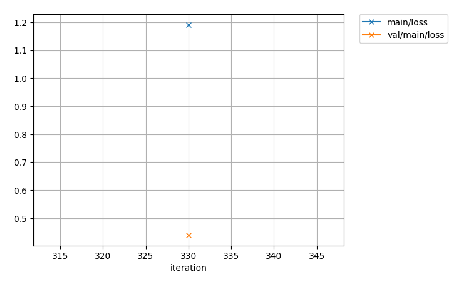

In [24]:
import cv2
import matplotlib.pyplot as plt
import os.path

# 座標軸の削除処理
fig,ax = plt.subplots()
ax.tick_params(labelbottom="off",bottom="off")
ax.tick_params(labelleft="off",left="off")
ax.set_xticklabels([]) 
ax.axis('off')

file = 'results/loss.png'
if os.path.exists(file):
  img = cv2.imread(file)
  show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
  plt.imshow(show_img)